In [194]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/var/folders/gq/w6zd94k524d3bqm_6rn2hrp80000gn/T/ipykernel_2102/2985171075.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [195]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [196]:
# константы
# ядро для генератора случайных чисел
my_seed = 27
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [197]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

In [198]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/winequality-white_for_lab.csv'
DF_all = pd.read_csv(fileURL)
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (4898, 13)


In [199]:
# оставляем в наборе данных только то, что нужно
DF_all = DF_all[['Y', 'fixed_acidity',
'volatile_acidity',
'citric_acid', 'chlorides',
'total_sulfur_dioxide',
'density', 'pH', 'sulphates',
'alcohol']].copy()
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (4898, 10)


Отложим 10% наблюдений для прогноза.

In [200]:
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.9, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [201]:
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,Y,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density
247,1,5.8,0.20,0.27,0.031,77.0,0.99050
4753,1,5.5,0.16,0.26,0.032,100.0,0.99076
1462,1,7.4,0.16,0.49,0.055,150.0,0.99170
4238,0,6.4,0.29,0.18,0.040,116.0,0.99736
381,1,7.2,0.28,0.26,0.046,179.0,0.99750


In [202]:
# первые 5 строк фрейма у столбцов 8-10
DF.iloc[:, 7:].head(5)

,pH,sulphates,alcohol
247,3.25,0.36,10.9
4753,3.43,0.77,12.0
1462,3.23,0.47,11.2
4238,3.14,0.50,9.2
381,3.10,0.52,9.0


In [203]:
# типы столбцов фрейма
DF.dtypes

Y                         int64
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
chlorides               float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

In [204]:
# считаем пропуски в каждом столбце
DF.isna().sum()

Y                       0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
chlorides               0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [205]:
DF_all['Y'].unique()  

array([1, 0])

In [206]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

Y
1    0.665
0    0.335
Name: count, dtype: float64

In [207]:
# описательные статистики
DF.iloc[:, :10].describe()

,Y,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000
mean,0.664701,6.850374,0.278309,0.333603,0.045843,138.553539,0.994047,3.187956,0.489294,10.510994
std,0.472149,0.841591,0.100751,0.120797,0.022089,42.525452,0.002994,0.151110,0.114214,1.234133
min,0.000000,3.800000,0.080000,0.000000,0.009000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,0.000000,6.300000,0.210000,0.270000,0.036000,108.000000,0.991760,3.080000,0.410000,9.500000
50%,1.000000,6.800000,0.260000,0.320000,0.043000,134.000000,0.993800,3.180000,0.470000,10.400000
75%,1.000000,7.300000,0.320000,0.390000,0.050000,167.250000,0.996113,3.280000,0.550000,11.400000
max,1.000000,14.200000,1.100000,1.660000,0.346000,440.000000,1.038980,3.820000,1.080000,14.200000


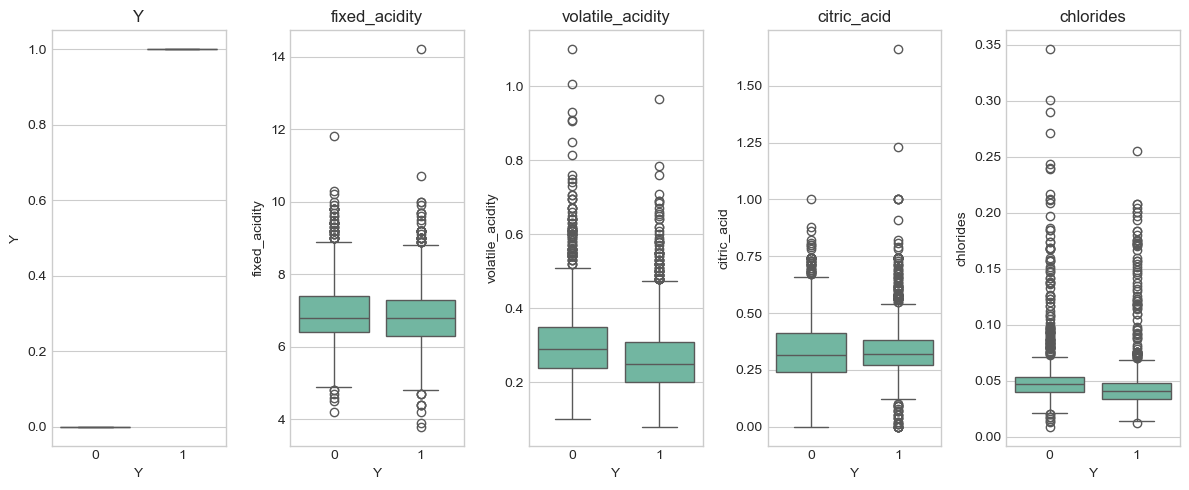

In [208]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

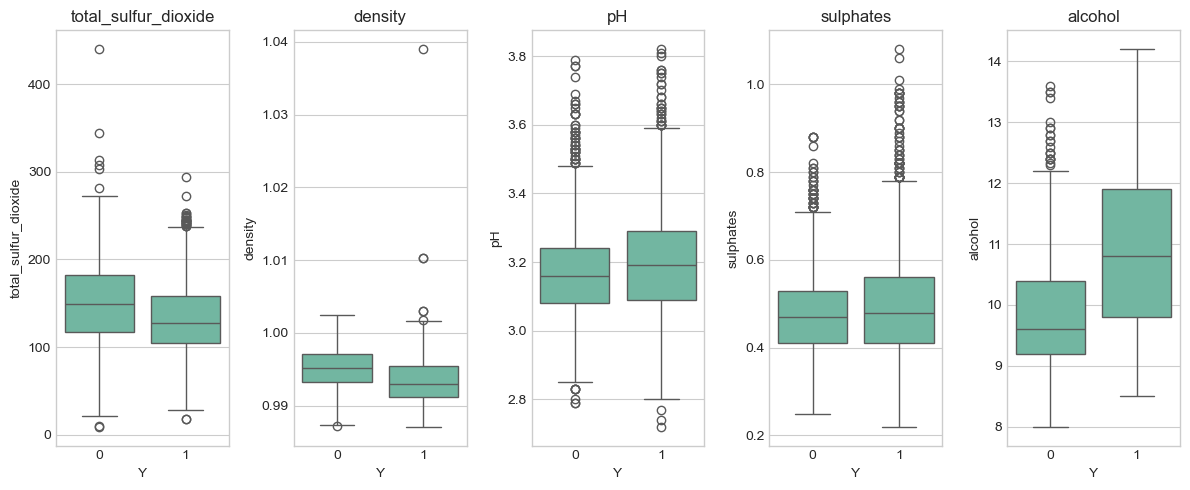

In [209]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

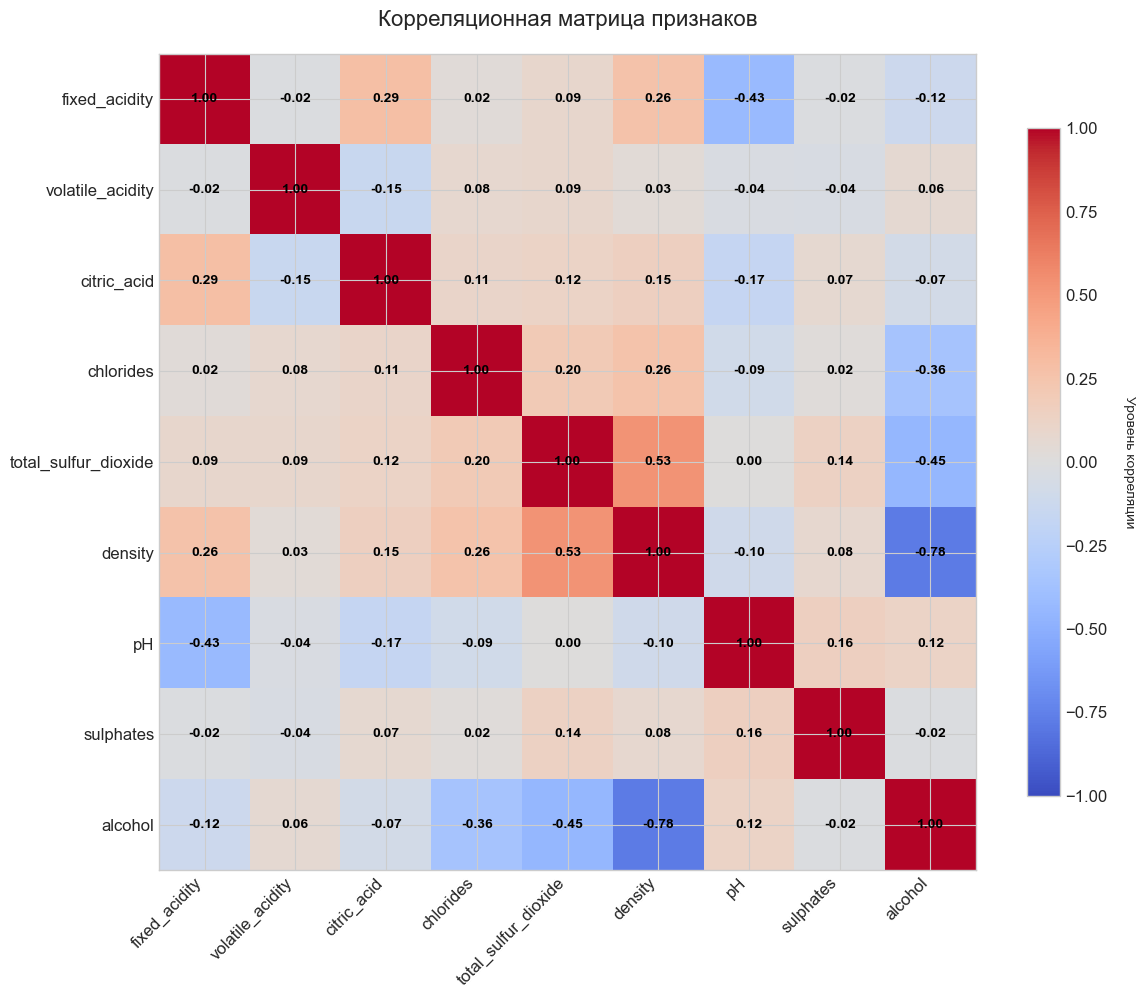

In [210]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))

# используем imshow вместо matshow
im = ax.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)

# координаты для названий строк и столбцов
tics_coords = np.arange(len(col_names))

# рисуем подписи
ax.set_xticks(tics_coords)
ax.set_yticks(tics_coords)
ax.set_xticklabels(col_names, fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(col_names, fontsize=12)

# добавляем значения корреляции в ячейки
for i in range(len(col_names)):
    for j in range(len(col_names)):
        text = ax.text(j, i, f'{corr_mat.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=10,
                      fontweight='bold')

# настраиваем легенду
cb = plt.colorbar(im, ax=ax, shrink=0.8)
cb.ax.tick_params(labelsize=12)
cb.set_label('Уровень корреляции', rotation=270, labelpad=20)

plt.title('Корреляционная матрица признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [211]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
# и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
# корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
32,density,alcohol,-0.777302,0.0
29,total_sulfur_dioxide,alcohol,-0.450259,0.0
5,fixed_acidity,pH,-0.426440,0.0
25,chlorides,alcohol,-0.356798,0.0
18,citric_acid,pH,-0.166848,0.0
8,volatile_acidity,citric_acid,-0.146713,0.0
7,fixed_acidity,alcohol,-0.119770,0.0
30,density,pH,-0.096230,0.0
23,chlorides,pH,-0.086028,0.0
20,citric_acid,alcohol,-0.072486,0.0


Методы снижения резмерности

In [212]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :9].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = 0.0   Станд. отклонение = 1.0
Столбец 5: среднее = 0.0   Станд. отклонение = 1.0
Столбец 6: среднее = -0.0   Станд. отклонение = 1.0
Столбец 7: среднее = 0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0


Регрессия на главные компоненты (PCR)

In [213]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)
# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n'
,
np.around(frac_var_expl, 3),
'\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.233 0.163 0.142 0.101 0.094 0.083 0.079 0.06  0.046] 
Общая сумма долей: 1.0


In [214]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8
0,1.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
1,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
2,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
3,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0
4,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,0.0
5,0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0
6,0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0
7,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0
8,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0


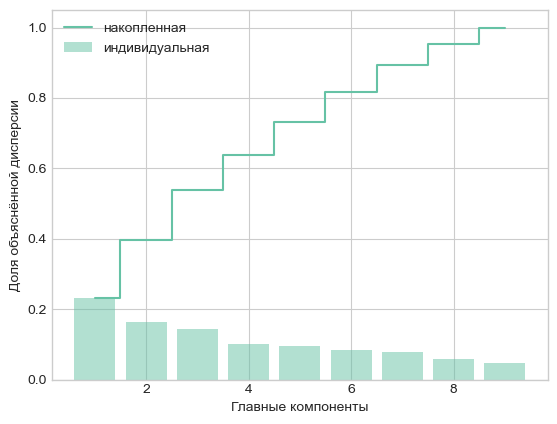

In [215]:
# график объяснённой дисперсии
plt.bar(range(1, 10), pca.explained_variance_ratio_, alpha=0.5,
align='center', label='индивидуальная')
plt.step(range(1, 10), np.cumsum(pca.explained_variance_ratio_),
where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

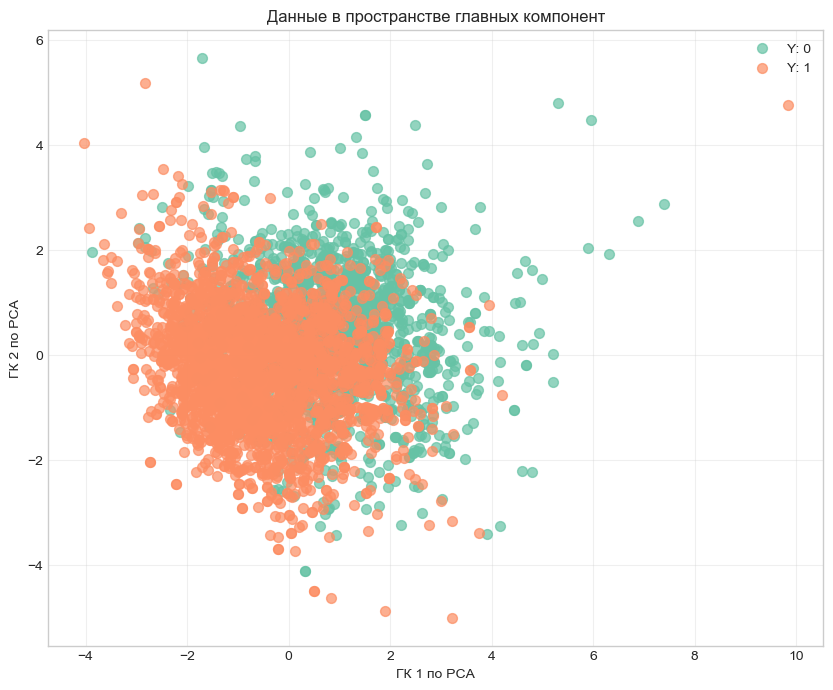

In [216]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК (только существующие классы)
plt.figure(figsize=(10, 8))

# Проверяем, какие классы существуют
unique_classes = DF['Y'].unique()

colors = ['red', 'blue', 'green']  # цвета для классов 0, 1, 2
for class_label in sorted(unique_classes):
    mask = (DF['Y'] == class_label)
    plt.scatter(X_train_pca[mask][:, 0],
                X_train_pca[mask][:, 1],
                label=f'Y: {class_label}',
                alpha=0.7,
                s=50)

plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.title('Данные в пространстве главных компонент')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [217]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
'\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.78


Метод частных наименьших квадратов

In [218]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=9)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF[['Y']].astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.161 0.134 0.13  0.089 0.089 0.065 0.076 0.087 0.095] 
Общая сумма долей: 0.926


In [219]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.025790,0.974210
1,-0.048621,1.048621
2,-0.081389,1.081389
3,1.031300,-0.031300
4,0.022337,0.977663
...,...,...
4403,-0.031731,1.031731
4404,0.007959,0.992041
4405,1.051258,-0.051258
4406,-0.011148,1.011148


In [220]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(1, 2930), (0, 1478)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

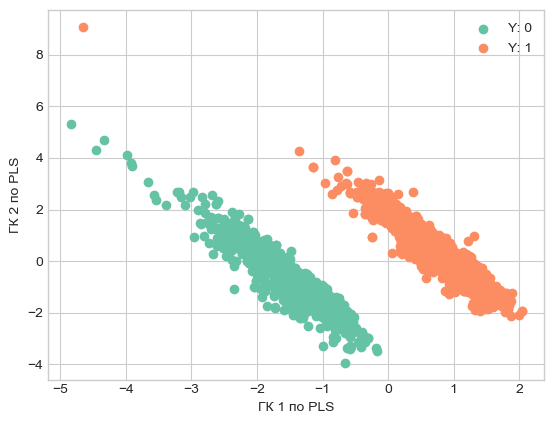

In [221]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

In [222]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
score = list()
score_models = list()
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)

score.append(np.around(np.mean(acc_blocks), 3))
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 1.0


# Методы сжатия   

## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [223]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [2.261] 
Коэффициенты моделей для классов:
 [[7.959 0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [224]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2,
penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
ridge_cv.C_

array([0.35938137])

In [225]:
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[2], ', перекрёстная проверка по 10 блокам',
'\nAcc = ', score[2], sep='')

IndexError: list index out of range

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_

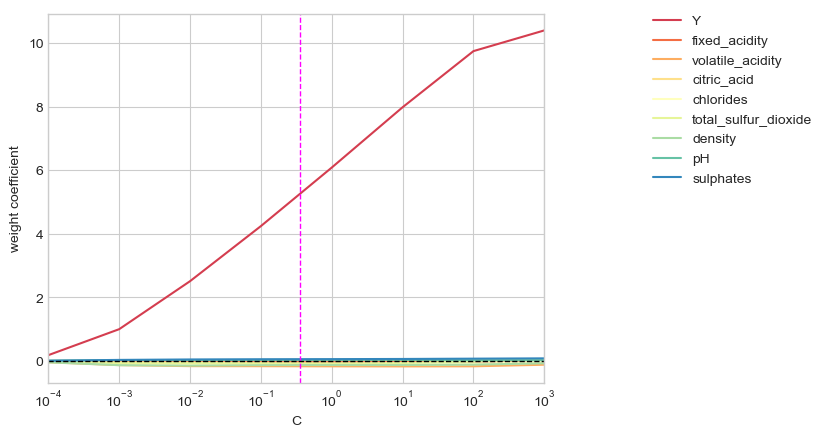

In [ ]:
# график динамики коэффициентов в ридж-регрессии
# модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

# Методы сжатия   

## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [ ]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [2.178] 
Коэффициенты моделей для классов:
 [[7.963 0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [ ]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
lasso_cv.C_

array([0.00077426])

In [227]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[3], ', перекрёстная проверка по 10 блокам',
    '\nAcc = ', score[3], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 1.0


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_

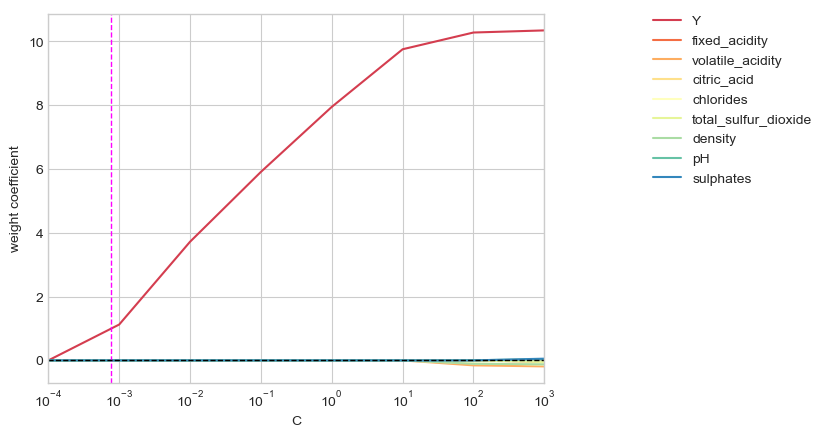

In [228]:
# график динамики коэффициентов в лассо-регрессии
# модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF.columns)

# Прогноз на отложенные наблюдения по лучшей модели

In [231]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,1.0
1,logit_ridge,1.0
2,logit_lasso,1.0
3,logit_lasso,1.0


In [235]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :9].values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       328

    accuracy                           1.00       490
   macro avg       1.00      1.00      1.00       490
weighted avg       1.00      1.00      1.00       490

